In [1]:
import json
import pathlib

from fastai.text import *

import numpy as np
import pandas as pd

# Data Preparation

In [2]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH = pathlib.Path("lm/telugu/data/")

In [3]:
LM_PATH=Path('lm/telugu/telugu_lm/')
LM_PATH.mkdir(exist_ok=True)

In [4]:
LANG_FILENAMES = [str(f) for f in PATH.rglob("*/*")]
print(len(LANG_FILENAMES))
LANG_FILENAMES[0:5]

482


['lm/telugu/data/AD/wiki_98',
 'lm/telugu/data/AD/wiki_83',
 'lm/telugu/data/AD/wiki_52',
 'lm/telugu/data/AD/wiki_82',
 'lm/telugu/data/AD/wiki_21']

In [5]:
LANG_TEXT = []
for i in LANG_FILENAMES:
    for line in open(i):
        LANG_TEXT.append(json.loads(line))
        
LANG_TEXT = pd.DataFrame(LANG_TEXT)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

In [ ]:
LANG_TEXT.to_csv(f"{LM_PATH}/Wiki_Telugu_Corpus.csv", index=False)

In [5]:
LANG_TEXT = pd.read_csv(f"{LM_PATH}/Wiki_Telugu_Corpus.csv")

In [ ]:
(LANG_TEXT.assign(labels = 0)
    .pipe(lambda x: x[['labels', 'text']])
    .to_csv(f"{LM_PATH}/Wiki_Telugu_Corpus2.csv", header=None, index=False))

# Some statistics of Telugu Wikipedia

In [ ]:
# Getting rid of the title name in the text field
def split_title_from_text(text):
    words = text.split("\n\n")
    if len(words) >= 2:
        return ''.join(words[1:])
    else:
        return ''.join(words)
    
LANG_TEXT['text'] = LANG_TEXT['text'].apply(lambda x: split_title_from_text(x))

### Number of documents

In [ ]:
LANG_TEXT.shape

### Number of words in all the documents

In [ ]:
LANG_TEXT['text'].apply(lambda x: len(x.split(" "))).sum()

### Number of unique tokens across documents

In [ ]:
len(set(''.join(LANG_TEXT['text'].values).split(" ")))

In [31]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    #texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts)) # splits the list into sublists for processing by each core
    # Lower and upper case is inside the tokenizer
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        #pdb.set_trace()
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [2]:
LANG_TEXT = pd.read_csv(f"{LM_PATH}/Wiki_Telugu_Corpus2.csv", header=None)#, chunksize=5000)

NameError: name 'LM_PATH' is not defined

In [8]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    LANG_TEXT, test_size=0.1) # split the data into train and validation sets

In [9]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts)) # generate a random ordering
val_idx = np.random.permutation(len(val_texts))

df_trn = trn_texts.iloc[trn_idx,:] # sort things randomly
df_val = val_texts.iloc[val_idx,:] # sort things randomly

df_trn.columns = ['labels', 'text']
df_val.columns = ['labels', 'text']

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False) # saving the data in our new format to disk

In [ ]:
chunksize = 10000
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [ ]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

In [ ]:
# create a tmp directory to store the upcoming numpy arrays
(LM_PATH/'tmp').mkdir(exist_ok=True)

# save the train and validation tokens in the tmp directories
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [5]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [6]:
# Identify the most common tokens and numericalizing the text
freq = Counter(p for o in tok_trn for p in o) 
freq.most_common(25)

[(',', 1407089),
 ('\n', 671359),
 ('\n\n', 434391),
 ('నుండి', 374401),
 ('ఉన్నాయి.', 307043),
 ('దూరంలో', 253309),
 ('గ్రామం', 253138),
 ('ఉంది.', 252431),
 ('10', 220890),
 ('గ్రామంలో', 190353),
 ('"', 180130),
 ('ఈ', 171605),
 ('మరియు', 168879),
 ('(', 155718),
 ('కి.మీ.', 155143),
 (')', 152823),
 ('5', 146692),
 ('కేంద్రం', 137280),
 ('సమీప', 134781),
 ('.', 120096),
 ('ఒక', 104031),
 ('సౌకర్యం', 94277),
 ('ద్వారా', 89490),
 ('కూడా', 88957),
 ('పైబడిన', 85834)]

In [7]:
# Truncating our vocab to ignore the rare words
max_vocab = 60000
min_freq = 5

itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq] # getting rid of the rare words
itos.insert(0, '_pad_') # 
itos.insert(0, '_unk_') # itos is the list of all the strings in the vocab

In [8]:
# creating a index-key dictionary for our vocabulary
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [ ]:
# creating a index representation for our train and validation dataset
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [ ]:
# saving our indexed representation of our dataset to disk
# we also save the index-word mapping to retrieve the complete text representation from these numpy arrays
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [9]:
# Loading the indexed representation of our dataset from disk
# we also load the index-word mapping to to help us convert the indexes to word datasets, if need be.
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [10]:
# checking vocabulary size
vs=len(itos)
vs,len(trn_lm)

(60002, 62100)

# Model Setup

In [32]:
# ! wget -nH -r -np http://files.fast.ai/models/wt103/
# mv models/ {LM_PATH}

In [11]:
em_sz,nh,nl = 400,1150,3

PRE_PATH = LM_PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

# itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb')) # mapping the itos from wiki to our own mapping
# stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [9]:
# we train from scratch so these are unused
# wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

# enc_wgts = to_np(wgts['0.encoder.weight'])
# row_m = enc_wgts.mean(0)

# wgts['0.encoder.weight'] = T(new_w)
# wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
# wgts['1.decoder.weight'] = T(np.copy(new_w))

# Language Model

In [12]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [13]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [14]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7 # if you're overfitting, increase this. Underfitting? decrease this.

In [15]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.unfreeze()

In [15]:
lr=1e-3
lrs = lr

In [16]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1) # last layer is the embedding weights

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      3.507504   3.560042   0.536065  



[3.5600417261725075, 0.5360646537065199]

In [17]:
learner.save('lm_telugu')

In [18]:
learner.load('lm_telugu')

In [19]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      3.923562   4.019726   0.500266  



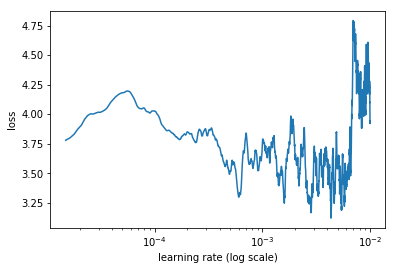

In [20]:
learner.sched.plot()

In [21]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      3.094194   3.251965   0.551908  



[3.25196513184556, 0.5519077254308237]

In [22]:
learner.save('lm_telugu2')

In [23]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      3.023268   3.232072   0.550196  
    1      2.962616   3.152982   0.552982                     
    2      2.845481   3.091412   0.557311                     
    3      2.904837   3.058079   0.558981                     
    4      2.934694   3.031383   0.56149                      
    5      2.809443   3.011194   0.562938                     
    6      2.821052   2.996692   0.563804                     
    7      2.745809   2.982939   0.564913                     
    8      2.752227   2.970708   0.566351                     
    9      2.713944   2.963013   0.566923                     
    10     2.74239    2.953206   0.567979                     
    11     2.698578   2.942487   0.568995                     
    12     2.661638   2.934464   0.569554                     
    13     2.645057   2.923704   0.570824                     
    14     2.659166   2.923686   0.570573                     



[2.9236859973026212, 0.5705727078739741]

In [24]:
learner.save('lm_telugu3')

In [25]:
learner.save_encoder('lm_telugu3_enc')

### Generate text

In [16]:
learner.load("lm_telugu3")

In [17]:
m = learner.model
m.eval()
# m[0].bs = 1

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150, dropout=0.105)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150, dropout=0.105)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400, dropout=0.105)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60002, bias=False)
    (dropout): LockedDropout(
    )
  )
)

## Inference

In [21]:
sen = """ఈ కేంద్రం నుండి"""

In [23]:
idxs = np.array([[stoi[p] for p in sen.strip().split(" ")]])
idxs

array([[13, 19,  5]])

In [25]:
p = m(VV(idxs))
type(p), len(p)

(tuple, 3)

In [32]:
p[0].shape, [x.shape for x in p[1]], [x.shape for x in p[2]]

(torch.Size([3, 60002]),
 [torch.Size([1, 3, 1150]), torch.Size([1, 3, 1150]), torch.Size([1, 3, 400])],
 [torch.Size([1, 3, 1150]), torch.Size([1, 3, 1150]), torch.Size([1, 3, 400])])

In [33]:
# p[0] is most likely the output vector

In [34]:
p[0].data


 -8.0130 -20.1957 -13.0121  ...  -18.8052 -17.5622 -18.2388
 -7.6993 -18.5297  -7.0673  ...  -19.3534 -18.0239 -19.1780
 -8.2334 -18.6780 -10.3912  ...  -17.1526 -18.2902 -17.0703
[torch.cuda.FloatTensor of size 3x60002 (GPU 0)]

In [41]:
# This command gives us the index of the word which has the highest probability for the last row
torch.topk(p[0][-1], 1)

(Variable containing:
 -8.1746
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  308
 [torch.cuda.LongTensor of size 1 (GPU 0)])

In [45]:
itos[torch.topk(p[0][-1], 1)[1].data[0]]

'నేరుగా'

In [46]:
# నేరుగా - this word makes sense, given the seed sentence.

In [47]:
def get_next(inp):
#     m[0].bs = 1 ## why?
    idxs = np.array([[stoi[p] for p in inp.strip().split(" ")]])
    p = m(VV(idxs))
    #pdb.set_trace()
    i = np.argmax(to_np(p)[0], 1)[0]
    try:
        r = itos[i]
    except:
        r = "oor"
    return r

def get_next(inp):
    idxs = np.array([[stoi[p] for p in inp.strip().split(" ")]])
    p = m(VV(idxs))
    #i = np.argmax(to_np(p)[0], 1)[0]
    i = torch.topk(p[0][-1], 1)[1].data[0]
    try:
        r = itos[i]
    except:
        r = "oor"
    return r


def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        print("input: [", inp, "] ||| c:[", c, "]")
        #pdb.set_trace()
        # res += c # ???
        res = res + " " + c
        #pdb.set_trace()
#         inp = ' '.join(inp.strip().split(" ")[1:]) + "  " + c
        inp = inp + " " + c
        inp = ' '.join(inp.strip().split(" ")[-5:]) + "  " + c
        
    return res

In [48]:
sen = """ఈ కేంద్రం నుండి"""

# o = get_next(sen)
o = get_next_n(sen, 10)
print(o)

input: [ ఈ కేంద్రం నుండి ] ||| c:[ నేరుగా ]
input: [ ఈ కేంద్రం నుండి నేరుగా  నేరుగా ] ||| c:[ _unk_ ]
input: [ నుండి నేరుగా  నేరుగా _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ నేరుగా _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ _unk_ _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ _unk_ _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ _unk_ _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ _unk_ _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ _unk_ _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ _unk_ _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
ఈ కేంద్రం నుండి నేరుగా _unk_ _unk_ _unk_ _unk_ _unk_ _unk_ _unk_ _unk_ _unk_


In [19]:
sen = """ఈ కేంద్రం"""# నుండి"""
sen

'ఈ కేంద్రం'

In [49]:
# o = get_next(sen)
o = get_next_n(sen, 10)
print(o)

input: [ ఈ కేంద్రం నుండి ] ||| c:[ _unk_ ]
input: [ ఈ కేంద్రం నుండి _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ నుండి _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ _unk_ _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ _unk_ _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ _unk_ _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ _unk_ _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ _unk_ _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ _unk_ _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ _unk_ _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
ఈ కేంద్రం నుండి _unk_ _unk_ _unk_ _unk_ _unk_ _unk_ _unk_ _unk_ _unk_ _unk_


In [50]:
sen = """ఒక సౌకర్యం"""# నుండి"""
print(sen)

o = get_next_n(sen, 10)
print(o)

ఒక సౌకర్యం
input: [ ఒక సౌకర్యం ] ||| c:[ కోసం ]
input: [ ఒక సౌకర్యం కోసం  కోసం ] ||| c:[ _unk_ ]
input: [ సౌకర్యం కోసం  కోసం _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ కోసం _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ _unk_ _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ _unk_ _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ _unk_ _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ _unk_ _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ _unk_ _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ _unk_ _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
ఒక సౌకర్యం కోసం _unk_ _unk_ _unk_ _unk_ _unk_ _unk_ _unk_ _unk_ _unk_


In [51]:
sen = """సౌకర్యం కూడా"""# నుండి"""
print(sen)

o = get_next_n(sen, 10)
print(o)

సౌకర్యం కూడా
input: [ సౌకర్యం కూడా ] ||| c:[ _unk_ ]
input: [ సౌకర్యం కూడా _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ కూడా _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ _unk_ _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ _unk_ _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ _unk_ _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ _unk_ _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ _unk_ _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ _unk_ _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
input: [ _unk_ _unk_  _unk_ _unk_  _unk_ ] ||| c:[ _unk_ ]
సౌకర్యం కూడా _unk_ _unk_ _unk_ _unk_ _unk_ _unk_ _unk_ _unk_ _unk_ _unk_


In [51]:
sen3[None].shape

(1, 1, 3)

In [38]:
p = m(VV(sen3))

In [40]:
pr = to_np(p)[0]
pr

array([[ -5.30443, -12.46248, -10.50603, ..., -11.83716, -11.21714, -11.24637],
       [ -8.09433, -14.54103,  -7.4647 , ..., -15.87726, -15.17229, -15.99565],
       [ -6.54617, -14.24266,  -8.8708 , ..., -13.21098, -13.97427, -13.58379]], dtype=float32)

In [45]:
pr_idxs = np.argmax(pr, 1)
[itos[x] for x in pr_idxs]

['క్రింది', 'నుండి', '_unk_']

In [159]:
def get_next(inp):
    m[0].bs = 1
    idxs = np.array([[stoi[p] for p in inp.split(" ")]])
    print(idxs)
    p = m(VV(idxs))
    print(p[0])
    i = np.argmax(to_np(p)[0])
    print(i)
    return itos[i]


sen = """ఈ కేంద్రం నుండి"""
# sen2 = [spacy_tok(sen)]
# sen2 = sen.split(" ")
get_next(sen)

[[13 19  5]]
Variable containing:
 -5.3044 -12.4625 -10.5060  ...  -11.8372 -11.2171 -11.2464
 -8.0943 -14.5410  -7.4647  ...  -15.8773 -15.1723 -15.9957
 -6.5462 -14.2427  -8.8708  ...  -13.2110 -13.9743 -13.5838
[torch.cuda.FloatTensor of size 3x60002 (GPU 0)]

1013


'క్రింది'

In [103]:
itos[np.argmax(to_np(p)[0])]

IndexError: list index out of range

# Classifier Tokens

In [27]:
CLAS_PATH = Path("lm/telugu/telugu_clas/")
LM_PATH.mkdir(exist_ok=True)

In [44]:
df_clas_data = pd.read_csv(CLAS_PATH/"ACTSA_telugu_polarity_annotated_UTF.txt", sep="\t", header=None)
df_clas_data[1] = df_clas_data[0].str[2:]
df_clas_data[0] = df_clas_data[0].str[0:2]

# Cleaning the target
df_clas_data[0] = df_clas_data[0].str.strip()
df_clas_data = df_clas_data[df_clas_data[0] != '+'].reset_index(drop=True)
df_clas_data[0] = df_clas_data[0].astype(np.float32)

df_clas_data.to_csv(CLAS_PATH/"Telugu_Sentiment_Data.csv", index=False)

# Ignoring neutral class for this exercise
df_clas_data = df_clas_data[df_clas_data[0] != 0].reset_index(drop=True)

# Creating train and validation sets
np.random.seed(42)
trn_keep = np.random.rand(len(df_clas_data))>0.1
df_trn = df_clas_data[trn_keep]
df_val = df_clas_data[~trn_keep]

# Saving train and validation sets to disk
df_trn.to_csv(CLAS_PATH/"Telugu_Sentiment_Data_Train.csv", header=None, index=False)
df_val.to_csv(CLAS_PATH/"Telugu_Sentiment_Data_Test.csv", header=None, index=False)

len(df_trn),len(df_val)

(2615, 315)

In [45]:
chunksize = 10000
df_trn = pd.read_csv(CLAS_PATH/"Telugu_Sentiment_Data_Train.csv", header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/"Telugu_Sentiment_Data_Test.csv", header=None, chunksize=chunksize)

In [46]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
0


In [47]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [48]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [49]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [50]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [51]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

# Classifier

In [52]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [53]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [54]:
Counter(trn_labels)

Counter({-1: 1290, 1: 1325})

In [55]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [56]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [57]:
c

3

In [58]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [59]:
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [60]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [61]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [62]:
m

SequentialRNN(
  (0): MultiBatchRNN(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150, dropout=0.3)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150, dropout=0.3)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400, dropout=0.3)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): ModuleList(
      (0): LinearBlock(
        (lin): Linear(in_features=1200, out_features=50, bias=True)
        (drop): Dropout(p=0.1)
        (bn): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): LinearBlock(
        (lin): Linear(in_features=50, out_features=3, bias=True)
        (drop): 

In [ ]:
# learner= md.get_model(opt_fn, em_sz, nh, nl, 
#     dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

# learner.metrics = [accuracy]
# learner.unfreeze()

In [63]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [64]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [65]:
learner

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 1150, dropout=0.105)
      )
      (1): WeightDrop(
        (module): LSTM(1150, 1150, dropout=0.105)
      )
      (2): WeightDrop(
        (module): LSTM(1150, 400, dropout=0.105)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60002, bias=False)
    (dropout): LockedDropout(
    )
  )
)

In [67]:
wd = 1e-7
wd = 0
learn.load_encoder('lm_telugu3_enc')

In [68]:
learn.freeze_to(-1)

In [70]:
learn.lr_find(lrs/1000)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 80%|███████▉  | 87/109 [00:01<00:00, 66.87it/s, loss=4.98] 


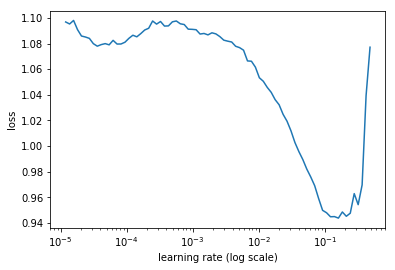

In [71]:
learn.sched.plot()

In [72]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8, 3))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.790954   0.721995   0.597884  



[0.7219952515193394, 0.5978835948875972]

In [73]:
learn.save('clas_0')

In [74]:
learn.load('clas_0')

In [75]:
learn.freeze_to(-2)

In [76]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8, 3))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.659717   0.643765   0.578704  



[0.6437652792249408, 0.5787037014961243]

In [77]:
learn.unfreeze()

In [78]:
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32, 10))

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.641418   0.650943   0.579365  
    1      0.639334   0.655019   0.603505                    
    2      0.624708   0.627397   0.63922                     
    3      0.614297   0.593653   0.652447                    
    4      0.5873     0.591706   0.666005                    
    5      0.587326   0.57287    0.667328                    
    6      0.567303   0.586514   0.663029                    
    7      0.56602    0.566119   0.662698                    
    8      0.558144   0.559359   0.669643                    
    9      0.562614   0.557676   0.669643                    
    10     0.538073   0.542816   0.6875                      
    11     0.528654   0.542713   0.707672                    
    12     0.524979   0.549868   0.704696                    
    13     0.520992   0.548514   0.681548                    



[0.5485136466366904, 0.6815476247242519]

In [79]:
learn.save('clas_1')